## How can a solar storm impact SSH? ##

On May 10-11, 2024 a major solar storm induced beautiful aurorae in a large part of Earth, including at latitudes where they are highly unusual. 
Less known (and less showy), let's see how such a solar storm has an impact on Sea Surface Height altimetry measurements.

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **

In [1]:
import os                              # a library that allows us access to basic operating system commands
import json                            # a library that helps us make JSON format files
import eumdac                          # a tool that helps us download via the eumetsat/data-store
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import zipfile                         # a library that support zipping/unzipping files
import xarray                          # a library that helps us work efficiently with multi-dimensional arrays
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import cartopy                         # a library that supports mapping and projection
import cartopy.crs as ccrs             # a library that supports projection
import cartopy.io.img_tiles as cimgt   # a subcomponent of cartopy that plots land tiles
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"
#from pathlib import Path               # a library that helps construct system path objects
import warnings                        # a library that supports managing warning messages

warnings.filterwarnings("ignore")

import glob

#we will look at the plot within the notebooks
%matplotlib inline


We will download data from May 10, 15:00UTC to May 11, 15:00UTC (end of episode May 12, 06:00TUC) in 2024 (solar storm) and 2022 (low solar activity). See https://kp.gfz-potsdam.de/en/figures/kp-since-1932 for an index of geomagnetic activity, in relation with aurorae probability.

In [3]:
# defining out search times; we will look 24 hours on the peak of the solar storm arrival on Earth in 2024, and two years before in 2022:
start2024 = datetime.datetime(2024, 5, 10, 15, 0)
end2024 = datetime.datetime(2024, 5, 11, 15, 0)
start2022 = datetime.datetime(2022, 5, 10, 15, 0)
end2022 = datetime.datetime(2022, 5, 11, 15, 0)

<hr>
<div class="alert alert-info" role="alert">

## 1. <a id='section1'></a>Downloading altimetry products from the EUMETSAT Data Store API
[Back to top](#TOC-TOP)

</div>

In [4]:
# Create a download directory for our products
download_dir2022 = os.path.join(os.getcwd(), "products/ionocase/2022/")
download_dir2024 = os.path.join(os.getcwd(), "products/ionocase/2024/")
os.makedirs(download_dir2022, exist_ok=True)
os.makedirs(download_dir2024, exist_ok=True)
download_data = True


In [5]:
if download_data:
# load credentials
    with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
        credentials = json.load(json_file)
        token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
        print(f"This token '{token}' expires {token.expiration}")

# create data store object
    datastore = eumdac.DataStore(token)

This token 'ddf9d9fb-d9f5-333f-9f60-c49e240b227c' expires 2024-07-03 14:58:33.889580


In [6]:
if download_data:
    #list Poseidon-4 collection IDs
    datastore = eumdac.DataStore(token)
    for collection_id in datastore.collections:
        if ("Poseidon-4" in collection_id.title):
            print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0237): Poseidon-4 Altimetry Level 1B Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0857): Poseidon-4 Altimetry Level 2P Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0855): Poseidon-4 Altimetry Level 2 High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0239): Poseidon-4 Altimetry Level 2 Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0851): Poseidon-4 Altimetry Level 1B High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0858): Poseidon-4 Altimetry Level 2P High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0859): Poseidon-4 Level 3 Altimetry High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0839): Poseidon-4 Altimetry Level 1B High Resolution (baseline version F08) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0841): Poseidon-4 Altimetry Level 2 High Resolution (baseline version F08) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0142): Poseidon

From the lists above, we will pick the "Poseidon-4 Altimetry Level 2 Low Resolution - Sentinel-6" for 2024 and the "Poseidon-4 Altimetry Level 2 Low Resolution (baseline version FXX) - Sentinel-6 - Reprocessed" for 2022 collection IDs. (retrieval done on June 28, 2024)

NB. the baseline number is evolving with new reprocessing; if you have older files from another baseline (see at the end of the folder/file name, just before the .SEN6 or .nc), replace them with the newest, *_do not use inhomogeneous baselines_* in computations nor comparisons.

To download only the files we'll be using, select only the "reduced" (RED) files only from the NTC delay ('NT') and download it. Note that in the reprocessed product, NTC is the only delay available.

In [7]:
if download_data:
    collectionID = 'EO:EUM:DAT:0854' #0854 operational  0842 reprocessed
    # space/time filter the collection for products
    selected_collection = datastore.get_collection(collectionID)

    products2024 = selected_collection.search(
        dtstart=start2024, 
        dtend=end2024,
        timeliness="NT")


In [8]:
if download_data:
    for product in products2024:
        for entry in product.entries:
            if 'S6A_P4_2__LR_RED_' in entry:
                with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), download_dir2024, fsrc.name), mode='wb') as fdst:
                    print(f'Downloading {fsrc.name}.')
                    shutil.copyfileobj(fsrc, fdst)
                    print(f'Download of file {fsrc.name} finished.')


Download of file S6A_P4_2__LR_RED__NT_129_045_20240511T141605_20240511T151218_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_044_20240511T131952_20240511T141605_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_043_20240511T122339_20240511T131952_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_042_20240511T112726_20240511T122339_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_041_20240511T103113_20240511T112726_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_040_20240511T093500_20240511T103113_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_039_20240511T083848_20240511T093500_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_038_20240511T074235_20240511T083848_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_037_20240511T064622_20240511T074235_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_036_20240511T055009_20240511T064622_F09.nc finished.
Download of file S6A_P4_2__LR_RED__NT_129_035_2024

In [9]:
if download_data:
    collectionID = 'EO:EUM:DAT:0842' #0854 operational 0842  reprocessed
    # space/time filter the collection for products
    selected_collection = datastore.get_collection(collectionID)

    products2022 = selected_collection.search(
        dtstart=start2022,
        dtend=end2022,
        timeliness="NT")


In [10]:
if download_data:
    for product in products2022:
        for entry in product.entries:
            if 'S6A_P4_2__LR_RED_' in entry:
                with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), download_dir2022 ,fsrc.name), mode='wb') as fdst:
                    print(f'Downloading {fsrc.name}.')
                    shutil.copyfileobj(fsrc, fdst)
                    print(f'Download of file {fsrc.name} finished.')

Download of file S6A_P4_2__LR_RED__NT_055_116_20220511T143622_20220511T153235_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_115_20220511T134009_20220511T143622_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_114_20220511T124356_20220511T134009_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_113_20220511T114743_20220511T124356_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_112_20220511T105130_20220511T114743_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_111_20220511T095517_20220511T105130_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_110_20220511T085904_20220511T095517_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_109_20220511T080252_20220511T085904_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_108_20220511T070639_20220511T080252_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_107_20220511T061026_20220511T070639_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_055_106_2022

Making two different datasets, for comparison (one 2022, the other 2024)

In [13]:
s6_files2022 = glob.glob(os.path.join(download_dir2022,'S6A_P4_2__LR_RED_*.nc'))
s6_files2024 = glob.glob(os.path.join(download_dir2024,'S6A_P4_2__LR_RED_*.nc'))
#we sort the files - by default it is "alphabetical" order, but pass numbers are also correctly ordered, which is our goal
# this sorting will provide with a well-orderer dataset/nc file (see next cell). 
# It is not absolutely vital to the present computation, but could be necessary in other cases
s6_files2022.sort()
s6_files2024.sort()

if s6_files2022 != []:
    s6data2022_01 = xarray.open_mfdataset(s6_files2022, group='data_01', combine='nested', concat_dim='time', compat='no_conflicts')
    s6data2022_01ku = xarray.open_mfdataset(s6_files2022, group='data_01/ku', combine='nested', concat_dim='time', compat='no_conflicts')
else:
    print('no files found')
if s6_files2024 != []:
    s6data2024_01 = xarray.open_mfdataset(s6_files2024, group='data_01', combine='nested', concat_dim='time', compat='no_conflicts')
    s6data2024_01ku = xarray.open_mfdataset(s6_files2024, group='data_01/ku', combine='nested', concat_dim='time', compat='no_conflicts')
else:
    print('no files found')

#definition of the variables we will need
s6data2022_01ocean = s6data2022_01.where(s6data2022_01['surface_classification_flag'] == 0)
lat2022 = s6data2022_01ocean['latitude']
lon2022 = s6data2022_01ocean['longitude']
time2022 = s6data2022_01ocean['time']
iono_cor2022 = s6data2022_01ocean['iono_cor_alt_filtered']

s6data2024_01ocean = s6data2024_01.where(s6data2024_01['surface_classification_flag'] == 0)
lat2024 = s6data2024_01ocean['latitude']
lon2024 = s6data2024_01ocean['longitude']
time2024 = s6data2024_01ocean['time']
iono_cor2024 = s6data2024_01ocean['iono_cor_alt_filtered']

Plotting the data 2022 vs 2024

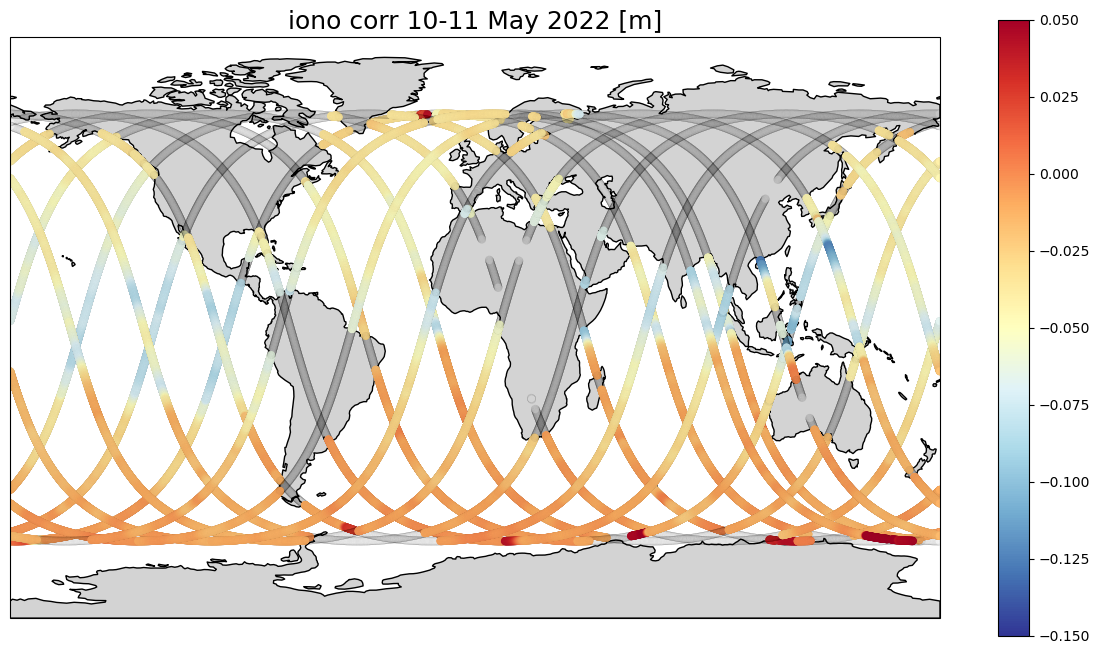

In [14]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
#zoom on the Mediterranean Western basin
#ax.set_extent([0, 25, 30, 50], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lon2022, lat2022, c=iono_cor2022, cmap='RdYlBu_r', marker='o',  vmin=-0.15, vmax=0.05, edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
#plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.title('iono corr 10-11 May 2022 [m]', size=18)
plt.show()

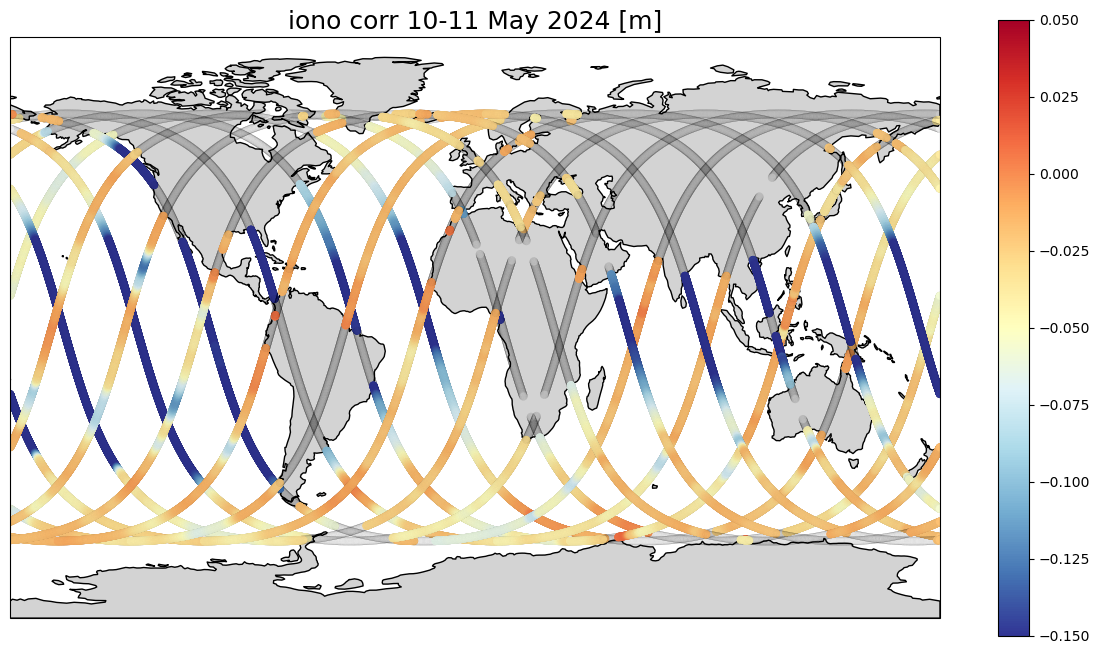

In [15]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
#zoom on the Mediterranean Western basin
#ax.set_extent([0, 25, 30, 50], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lon2024, lat2024, c=iono_cor2024, cmap='RdYlBu_r', marker='o',  vmin=-0.15, vmax=0.05, edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
#plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.title('iono corr 10-11 May 2024 [m]', size=18)
plt.show()

We can see that descending passes have lower values (higher absolute values) than ascending passes at least at temperate/tropical latitudes. 
In fact, you have to realize that daylight is important here, and descending passes will be at the opposite of the diurnal phase than their ascending counterparts (said otherwise, if the Sun is shining on the side of the Earth where the satellite is descending, it will be night on the other side, where it is ascending, or vice-versa). There are a bit more than 24 tracks a day (27), so it roughly means that during one day all descending passes will be under daylight as here (or all ascending, it shifts over time)
solar_time = UTCtime + longitude / π * 12h (rough computation, but it is sufficient here to pinpoint the fact)

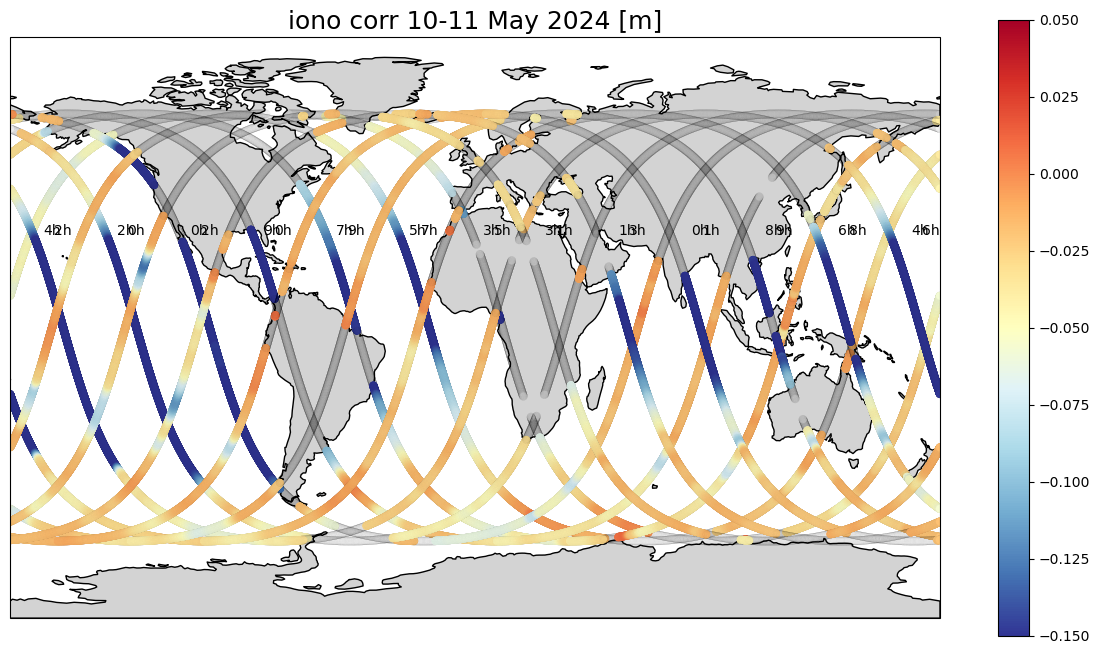

In [62]:
#Compute local solar time at lat 0(?) and write it on the plot close to the track (or ... sun/moon icons? shadow?))

dlat = 0.05 #step in latitude between two 1Hz measurements
solar_time_eq2024 = time2024.sel(time=(lat2024 > 0-dlat/2) & (lat2024 < 0+dlat/2)) + \
            ( lon2024.sel(time=(lat2024 > 0-dlat/2) & (lat2024 < 0+dlat/2)) / np.pi * 12).astype('timedelta64[ns]')
#TODO shift a bit the text from equator not to have overlaps between asc & desc info 
lattext2024 = lat2024.sel(time=(lat2024 > 0-dlat/2) & (lat2024 < 0+dlat/2)).values
#define longitude in -180 - 180 (native is 0-360))
lontext2024 = (lon2024.sel(time=(lat2024 > 0-dlat/2) & (lat2024 < 0+dlat/2)).values + 180) % 360 - 180

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
#zoom on the Mediterranean Western basin
#ax.set_extent([0, 25, 30, 50], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lon2024, lat2024, c=iono_cor2024, cmap='RdYlBu_r', marker='o',  vmin=-0.15, vmax=0.05, edgecolors='black', linewidth=0.01)
#text or annonate with solar_time_eq2024 (hour only) at lattext2024 lontext2024
for i in range(0,len(lontext2024)):
    localhour = str(solar_time_eq2024[i].values)[12:13] + 'h'
    ax.text(lontext2024[i], lattext2024[i], localhour, verticalalignment='center', horizontalalignment='center')

cbar = plt.colorbar(tracks)
#plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.title('iono corr 10-11 May 2024 [m]', size=18)
plt.show()

Some statistics in 2024 vs 2022

In [40]:
#A few statistics
print('2022', ' min: ', np.nanmin(iono_cor2022.values), 'mean', np.nanmean(iono_cor2022.values), 'std:', np.nanstd(iono_cor2022.values) )
print('2024', ' min: ', np.nanmin(iono_cor2024.values), 'mean', np.nanmean(iono_cor2024.values), 'std:', np.nanstd(iono_cor2024.values) )

2022  min:  -0.1302 mean -0.032664700822989744 std: 0.024534529791143903
2024  min:  -0.45320000000000005 mean -0.06682868939565513 std: 0.071763807906663


In [41]:
# histogram iono values per lat bins asc / desc 2022 vs 2024

https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/NT-Nencioli_FilteredIonosphericCorrection.pdf

The dual-frequency ionospheric correction is directly proportional to the ionospheric TEC which is primarily controlled by solar radiation. Thus, the spatial distribution and temporal variability of the correction are function of three main factors:<br>
• Solar activity: values of the correction increase during periods of stronger solar activity<br>
• Local time: values of the correction are higher during local day times (maximum values around local 14:00) and lower during local night times (minimum values around local 2:00)<br>
• Latitudinal location: correction values are highest within the tropics (maxima at around ±15◦ of latitude) and smallest at high latitudes<br>